## TC 5033
### Word Embeddings

<br>

#### Alumnos:
*   Andre Nicolai Gutiérrez Bautista
*   Fernando Guzmán Briones
*   Julio Osvaldo Hernández Bucio
*   Genaro Rodríguez Vázquez

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


## Import libraries

First it is required to import all the dependencies by using pip install or conda install, depending on the used tool.
Once the installation is over remember to reset the environment.
<br>
If you already installed the dependencies you can comment them.

In [1]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
# !pip install scikit-plot
# !pip install portalocker
# !pip install torchdata
# !pip install torchtext
# !pip install torchvision torchaudio
# !pip install torchmetrics

In [2]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F
from torch import long, as_tensor, cat
# For sample_text
from random import randint
# For confusionMatrix
from torchmetrics import ConfusionMatrix
from seaborn import heatmap
from torch.utils.data import DataLoader

In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Loading and tokenization

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

### Load the AG_NEWS dataset




In [4]:
# Load the AG_NEWS dataset.
train_dataset, test_dataset = AG_NEWS()
# Converts it to a map-style dataset.
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

### Tokenization Setup

In [5]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [6]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
# set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [7]:
# Test tokenization
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


### Data Splitting

In [8]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [9]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [10]:
# Get the length of every dataset to verify that the split was correct.
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


### Data processing and data loader

In [11]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [12]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

#### Save Data in loader

In [13]:
# Create the dataloader instances for each of the data sets.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)


## Build the RNN model

### Model definition and training methods

#### RNN Model Class

In [15]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)

        self.rnn = nn.GRU(input_size=embed_size, hidden_size=hidden, num_layers=layers, batch_first=True)

        self.fc = nn.Linear(hidden, num_classes)
        # Include a weight initializer to improve accuracy.
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        embedded = self.embedding_layer(x)
        # Pass the embedded input sequences through the RNN layer.
        output, _ = self.rnn(embedded)
        # Extract the Hidden State at the Last Time Step.
        last_hidden_state = output[:, -1, :]
        # Pass the last hidden state through a fully connected layer to get the logits.
        logits = self.fc(last_hidden_state)
        return logits

### Training methods

####Accuracy Method

In [16]:
def accuracy(model, loader):
  # Initialize counters and cost accumulator
  total = 0  # Total number of samples
  correct = 0  # Number of correctly classified samples
  cost = 0.  # Accumulator for the cost (loss)

  with torch.no_grad():
    model.eval() # Set the model to evaluation mode
    for data in loader:
      # Unpackage the dataset in np.arrays and labels.
      inputs, labels = data[0], data[1]
      # outputs = net(images)
      xi = inputs.to(device=device)
      yi = labels.to(device=device)

      yi = yi.type(torch.LongTensor) # <---- Here (casting)
      yi = yi.to(device=device)

      # Make the predictions.
      scores = model(xi)

      # Calculate the Negative Log Likelihood (NLL) loss. Use the log_softmax to be able to use the logarithm input.
      criterion = nn.NLLLoss()
      cost += criterion(F.log_softmax(scores, dim=1), yi).item()

      # Obtain the predicted labels
      _, pred = torch.max(scores, 1)

      # Append the results to update the counters
      total += pred.size(0)
      correct += (pred == yi).sum().item()

  # Return the total cost value and precision of the dataset (loss % accuracy)
  return cost/len(data), float(correct)/total

#### Train method

In [17]:
def train(model, optimiser, epochs=100):
  # Important to include the following line to move the model to the current device
  model = model.to(device=device)
  # Initialize variables for tracking total training and validation costs
  train_cost = 0
  val_cost = 0.

  # Perform the training for each epoch in the epoch range defined into the hyperparameters section.
  for epoch in range(epochs):
    # Initialize variables for tracking training statistics within each epoch
    running_loss = 0.0
    train_correct_num  = 0.
    train_total = 0.
    train_cost_acum = 0

    # Be sure to run the trainings using the training dataset and not the test neither the validation datasets.
    for i, data in enumerate(train_loader, 0):
      # Set the model to training mode
      model.train()

      # Extract inputs and labels from the batch
      inputs, labels = data[0], data[1]

      xi = inputs.to(device=device)
      yi = labels.to(device=device)

      yi = yi.type(torch.LongTensor) # <---- Here (casting)
      yi = yi.to(device=device)

      # forward pass
      # Obtain model predictions
      scores = model(xi)

      # Zero the gradients, backward pass, and optimization
      optimiser.zero_grad()
      criterion = nn.NLLLoss()
      cost = criterion(F.log_softmax(scores, dim=1), yi)
      cost.backward()
      optimiser.step()

      # Obtain the predicted class labels
      _, pred = torch.max(scores.data, 1)

      # Update training statistics
      train_correct_num += (pred == yi).sum().item()
      train_total += scores.size(0)
      train_cost_acum += cost.item()

    # Calculate the cost and accuracy after each trained epoch
    # We must perform the evaluation of validation dataset (not training)
    # If we use the same dataset for the calculation and accuracy then we would have a memory leak issue (undesired).
    val_cost, val_acc = accuracy(model, val_loader)

    ### Train total -> Trained dataset size
    ### train_correct_num  -> Amount of items correctly clasified.
    ### train_acc  -> Model accuracy (Desired value: close to 1).
    ### train_cost  -> Loss (Acumulated error. Desired value: close be 0)
    train_acc = float(train_correct_num)/train_total
    train_cost = train_cost_acum/i

    # Monitorize the results each 3 epochs to avoid spam and to use the correct amount of epochs
    if epoch%3 == 0:
      print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f},'
                      f' lr: {optimiser.param_groups[0]["lr"]:.6f}')

## Model Training

### Setup

#### Hyperparameters

In [14]:
# Required hyperparameters to create the RNN Model as the number of neurons and the number of clases (in this case 4).
EMBEDDING_SIZE = 300
NEURONS = 256
LAYERS = 2
NUM_CLASSES = 4

# Hyperparameters to run the training
epochs = 10
lr = 0.0001

#### Instantiation

In [18]:
# Instantiate a new RNN Model as it was build in the "Model Definition" section.
gru_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
optimiser = torch.optim.Adam(gru_model.parameters(), lr=lr)

### Training and accuracy evaluation

In [19]:
train(gru_model, optimiser=optimiser,  epochs=epochs)

Epoch:0, train cost: 1.113859, val cost: 14.244642, train acc: 0.4785, val acc: 0.765000, lr: 0.000100
Epoch:3, train cost: 0.284791, val cost: 8.006878, train acc: 0.9017, val acc: 0.879500, lr: 0.000100
Epoch:6, train cost: 0.194713, val cost: 7.039862, train acc: 0.9352, val acc: 0.899500, lr: 0.000100
Epoch:9, train cost: 0.137156, val cost: 7.592854, train acc: 0.9552, val acc: 0.896750, lr: 0.000100


In [20]:
print(accuracy(gru_model, test_loader)[1])

0.8952631578947369


### Inference with sample text

In [21]:
def sample_text(model, loader):
  model.eval()  # Set the model to evaluation mode.

  with torch.no_grad():
    # Select a random sample from the test loader.
    num = randint(0, len(loader.dataset) - 1)
    label, text = loader.dataset[num]

    # Tokenize and convert the text to tensor.
    text_tensor = torch.tensor(vocab(tokeniser(text)), dtype=torch.long).unsqueeze(0)

    # Make prediction using the model.
    prediction = model(text_tensor.to(device))

    # Get the predicted label.
    predicted_label = torch.argmax(prediction).item()

    print(f'Sample text: {text}')
    print(f'Predicted label: {labels[predicted_label]}')
    print(f'Real label: {labels[label - 1]}')

In [22]:
# Get a random sample text.
sample_text(gru_model, test_loader)

Sample text: 14 Nations to Participate in Plan to Reduce Methane Thirteen countries agreed yesterday to join a global plan proposed by the Bush administration to curb methane emissions by capturing the greenhouse gas and using it as an energy source before it is released into the atmosphere.
Predicted label: World
Real label: Sci/Tech


### Model results visualization

In [27]:
def plot_confusion_matrix(model, loader):
  model.eval() # Set the model to evaluation mode.

  all_preds = []
  all_labels = []

  with torch.no_grad():
    for data in loader:
      inputs, labels_ = data[0].to(device), data[1].to(device)

      # Obtain model predictions.
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels_.cpu().numpy())

  # Calculate confusion matrix using torchmetrics
  cf = ConfusionMatrix(num_classes=len(labels), task='multiclass', normalize='all')
  cm = cf(torch.tensor(all_preds), torch.tensor(all_labels))

  # Plot the confusion matrix using seaborn
  ax = heatmap(cm*4, annot=True, fmt='.2%', cmap='Blues',
              xticklabels=labels, yticklabels=labels)
  _ = ax.set_xlabel('Preds')
  _ = ax.set_ylabel('Real')

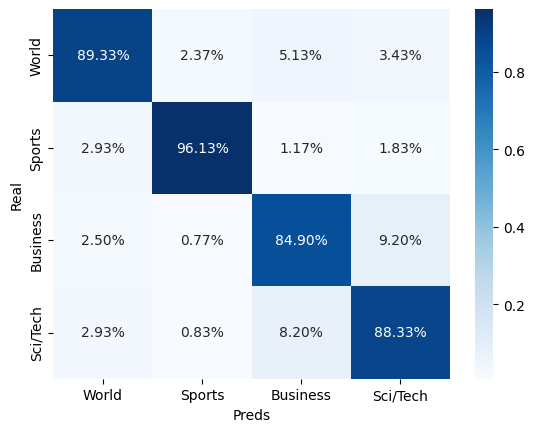

In [28]:
plot_confusion_matrix(gru_model, test_loader)